# Abstract

This report analyzes the factors of a song that influence  music enjoyment using Spotify listening data received through a request to the platform. The dataset includes variables such as track popularity, loudness, danceability, acousticness, and other audio features. We employ exploratory data analysis (EDA), LASSO regression, logistic regression, and ensemble models like Random Forest and XGBoost to predict whether a song was "enjoyed" or not. While the models showed only modest accuracy (with AUC values ranging from 0.55 to 0.58), the results suggest that Spotify likely leverages far more granular, proprietary data about individual users that was not made available for this analysis. The key takeaway is that companies like Spotify collect and utilize highly detailed user metrics to curate personalized recommendations, but these methods and the extent of data collection remain opaque to the public. This raises important considerations about data privacy and the effort platforms invest in understanding user behavior.

# Executive Summary  

This report explores what makes a song enjoyable by analyzing Spotify listening data. The goal was to uncover the key features of songs that influence listening preferences and determine whether publicly available data can predict which songs people enjoy. Using audio features such as track popularity, energy, danceability, loudness, and acousticness, the analysis applied both simple statistical models and more advanced machine learning techniques. 

The results showed that certain song characteristics are linked to enjoyment. Songs that are popular, energetic, and easy to dance to were more likely to be enjoyed, while quieter or highly acoustic songs were less favored. However, despite identifying these trends, the models’ ability to predict enjoyment was limited, with accuracy hovering around 55-57%. This means that, while some patterns could be found, the publicly available data alone is not enough to fully explain why someone enjoys a particular song.  

The modest accuracy of these models suggests that Spotify’s ability to deliver highly personalized recommendations depends on far more detailed and specific data than what is publicly shared. Beyond basic song features, Spotify likely uses extensive behavioral data, such as when users listen, their mood, habits, and patterns over time. It is also possible that third-party data and other forms of personal identification help refine their algorithms, giving the platform a deeper understanding of individual preferences.  

This raises important questions about transparency and data privacy. Users benefit from accurate, personalized music recommendations, but they often do not realize how much data is being collected and analyzed to achieve this. Platforms like Spotify operate sophisticated systems that rely on hidden, proprietary data, which gives them a significant advantage in understanding user behavior but also leaves users in the dark about how their information is used.  

In conclusion, while this report highlights some factors that influence song enjoyment, it also underscores the limits of publicly available data. The findings point to the hidden power of proprietary data held by streaming services, which allows them to create far more accurate and tailored recommendations. Future work could explore richer datasets that include listening behavior, time-based trends, and contextual factors to better understand what truly drives music preferences.  

In [1]:
%%capture
# Loading in libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import seaborn as sns

In [2]:
%%capture
# Loading in Data
avg_play = pd.read_csv("Cleaned_Data/Full_Data_With_Plays.csv").rename(columns={'track_name_x':'track_name',
                                                                        'artist_name_x':'artist_name',
                                                                        'artist_id_x':'artist_id',
                                                                        'genres_x':'genres',
                                                                        'track_popularity_x':'track_popularity'}).drop(columns=['track_name_y', 'artist_name_y', 
                                                                                                                               'artist_id_y', 'genres_y', 'track_popularity_y'])
features = avg_play[['artist_id', 'track_name', 'genres', 'track_popularity', 'artist_name', 'track_id', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature']]

# Introduction

Music streaming platforms like Spotify have transformed the way people consume music, offering personalized recommendations based on listening habits. These platforms promise to understand individual tastes, curating playlists and suggestions tailored to each user. The ability to predict what someone will enjoy listening to is an impressive technical feat and imperative to the success of an entity such as Spotify, but it also raises questions about the extent of the data they collect and the methods used to generate these recommendations.

The motivation behind this project stems from a curiosity about the factors that influence music enjoyment and how much can be inferred from Spotify's publicly accessible data. While Spotify claims to provide a personalized experience, it is unclear how much of that personalization is driven by user listening patterns and song information versus proprietary data and algorithms that remain opaque. This project seeks to examine whether publicly available audio features and metadata can effectively predict song enjoyment and, in turn, to highlight the limitations of accessible data compared to what platforms like Spotify may actually use.

The dataset for this analysis was obtained by request from Spotify and contains various audio and song-level features, such as track popularity, danceability, loudness, speechiness, and acousticness. Each row represents a song listened to, with an outcome variable denoting whether the song was "enjoyed" based on metrics like play count and completion rate. 

The remainder of this report is organized as follows:

- Section 4 presents exploratory data analysis (EDA) and visualizations, revealing relationships between features like loudness, danceability, and enjoyment.

- Section 5 describes the predictive models applied, including LASSO regression, logistic regression, and ensemble methods such as Random Forest and XGBoost. The models' performance is evaluated, and key predictors are identified.

- Section 6 focuses on the interpretation of the results, comparing models and discussing their limitations. The results underscore the modest predictive power of the available data.

- Section 7 concludes the report with reflections on the findings and recommendations for future work. It highlights the hidden depth of Spotify's proprietary data and raises important considerations about data privacy and transparency.

Through this project, the aim is to shed light on how much can be inferred from publicly available data, as well as its limitations.

# Exploratory Data Analysis

To understand the data and prepare it for modeling, we conduct an exploratory data analysis (EDA). This section details the steps taken to investigate the data, uncover key patterns, and ensure the dataset was ready for further analysis.

## Distribution of Number of Plays

The first step was to examine the number of plays for each song. Understanding the spread of this variable helps identify whether listening frequency is a useful signal for enjoyment.

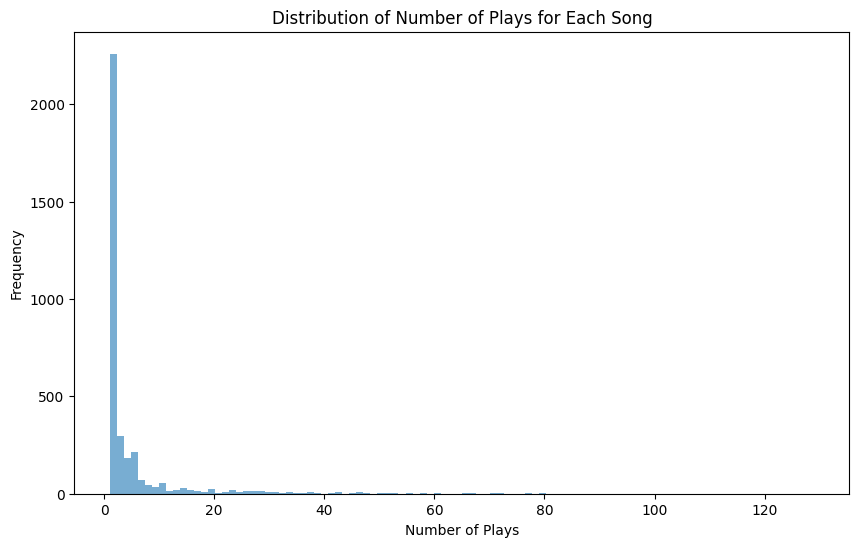

In [5]:
#@title Cell1
plt.figure(figsize=(10, 6))
plt.hist(avg_play['total_plays'], bins=100, alpha=0.6, label='Number of Plays')
plt.xlabel('Number of Plays')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Plays for Each Song');

The histogram reveals that the majority of songs were played only once, with a small subset receiving multiple plays. This initial insight suggested the need to categorize songs into "1 Play" versus "Multiple Plays".

## Categorizing Songs by Play Count

To simplify the analysis, we divide songs into two categories, with one representing single-play songs and the other being songs played multiple times

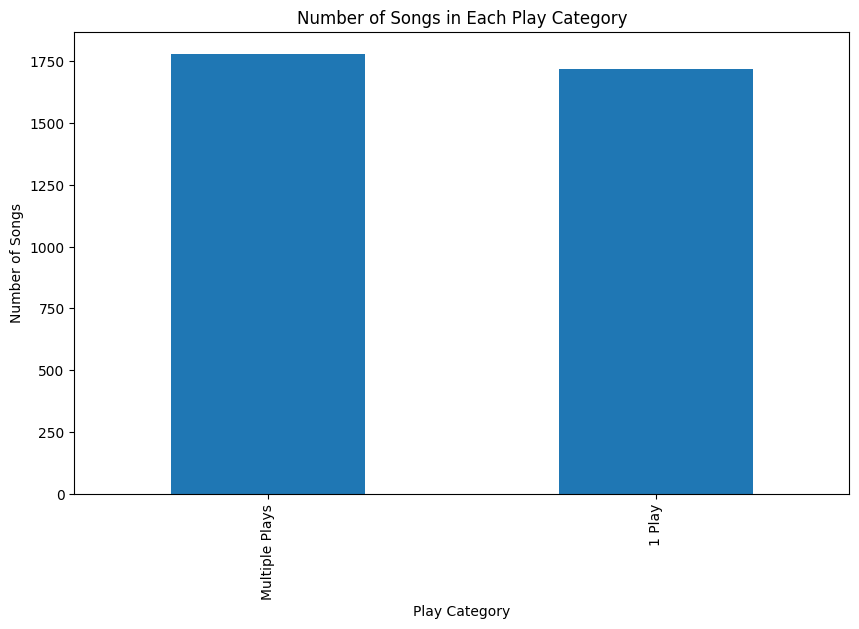

In [7]:
#@title Cell2
avg_play['play_category'] = '1 Play'
avg_play.loc[avg_play['total_plays'] >= 2, 'play_category'] = 'Multiple Plays'
plt.figure(figsize=(10, 6))
avg_play['play_category'].value_counts().plot(kind='bar')
plt.xlabel('Play Category')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Play Category');

The bar chart shows a pretty even split between the two categories.

## Completion Rates

We next analyze the average completion rate for songs to see how fully they were listened to.

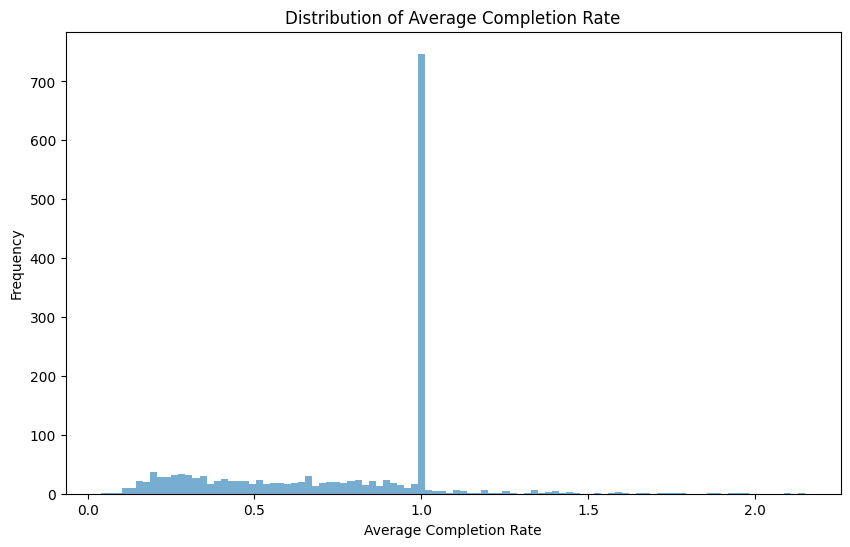

In [8]:
#@title Cell3
plt.figure(figsize=(10, 6))
plt.hist(avg_play[avg_play['play_category'] == '1 Play']['avg_completion_rate'], bins=100, alpha=0.6, label='Average Completion Rate')
plt.xlabel('Average Completion Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Average Completion Rate')
plt.show();

The histogram highlights a skewed distribution, with some songs having very high completion rates even when only played once. This suggests that high completion rates might indicate enjoyment.

## Defining "Enjoyed" Songs

Using the completion rate and play count, we create a binary column enjoyed to identify songs that were either replayed or fully listened to (completion rate ≥ 1.25).

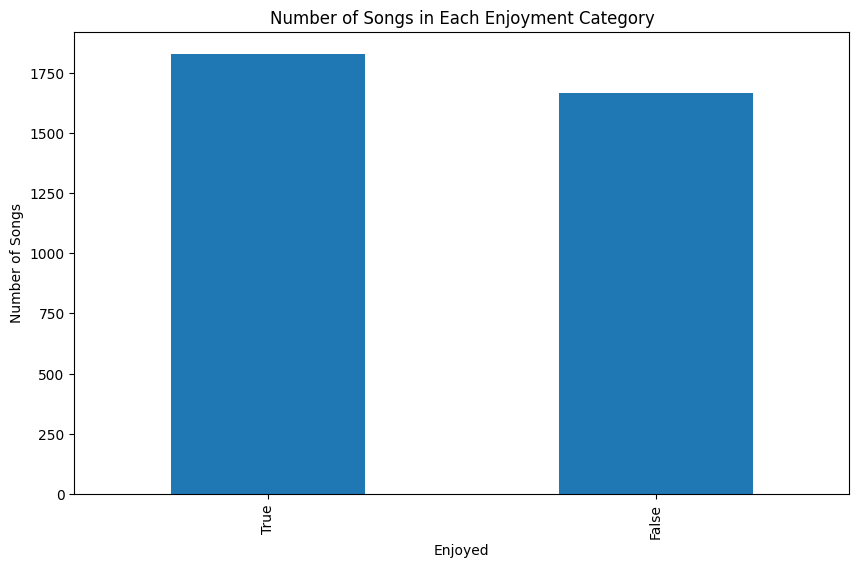

In [9]:
#@title Cell4
avg_play['enjoyed'] = (avg_play['avg_completion_rate'] >= 1.25) | (avg_play['total_plays'] > 1)
plt.figure(figsize=(10, 6))
avg_play['enjoyed'].value_counts().plot(kind='bar')
plt.xlabel('Enjoyed')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Enjoyment Category')
plt.show();

This bar chart confirmed a near-even split between songs classified as "enjoyed" and "not enjoyed," providing a balanced dataset for modeling.

## Exploring Audio Features

We next the distribution of key audio features between "enjoyed" and "not enjoyed" songs. Features like danceability, energy, and loudness were investigated.

The resulting plots (shown in Figure 1 in the appendix) showed clear differences for certain features like danceability, where enjoyed songs tended to score higher. Meanwhile, acousticness appeared lower for songs classified as enjoyed, suggesting that quieter or highly acoustic songs were less likely to be favored.

## Standardizing and Transforming Features

To address skewness (shown in Figure 2 in the appendix), we standardize and transform key features like loudness, acousticness, and speechiness. These transformations ensure that outliers do not disproportionately influence the analysis. Loudness was standardized to have a mean of 0 and a standard deviation of 1. Features like acousticness, speechiness, and liveness were log-transformed to reduce skewness. The updated distributions revealed smoother, more comparable patterns between enjoyed and not enjoyed songs across all features.

In [17]:
#@title Cell7
# Make a column called 'enjoyed' in avg_play that is True if the avg_completion_rate is greater than 1.25 or the total_plays is greater than 1
avg_play['enjoyed'] = (avg_play['avg_completion_rate'] >= 1.25) | (avg_play['total_plays'] > 1)

In [18]:
%%capture
avg_play2 = avg_play.copy()
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_popularity']

# One-hot encode the 'time_signature' column and the 'key' column
avg_play2 = pd.get_dummies(avg_play2, columns=['time_signature', 'key'])


# Plot the distribution of each audio feature in a grid of subplots
plt.figure(figsize=(20, 30))
for i, feature in enumerate(audio_features):
    plt.subplot(5, 2, i + 1)
    plt.hist(avg_play2[avg_play2['enjoyed'] == True][feature], bins=100, alpha=0.6, label='Enjoyed', color='blue', density=True)
    plt.hist(avg_play2[avg_play2['enjoyed'] == False][feature], bins=100, alpha=0.6, label='Not Enjoyed', color='red', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)
    plt.legend()

In [19]:
%%capture
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'valence',
       'liveness', 'tempo', 'track_popularity']


# Standardize loudness
avg_play2['loudness'] = (avg_play2['loudness'] - avg_play2['loudness'].mean()) / avg_play2['loudness'].std()

# apply log(1 +x) transformation to loudness, acousticness, speechiness, and liveness
avg_play2['acousticness'] = np.log1p(avg_play2['acousticness'])
avg_play2['speechiness'] = np.log1p(avg_play2['speechiness'])
avg_play2['liveness'] = np.log1p(avg_play2['liveness'])

plt.figure(figsize=(20, 30))
for i, feature in enumerate(audio_features):
    plt.subplot(5, 2, i + 1)
    plt.hist(avg_play2[avg_play2['enjoyed'] == True][feature], bins=100, alpha=0.6, label='Enjoyed', color='blue', density=True)
    plt.hist(avg_play2[avg_play2['enjoyed'] == False][feature], bins=100, alpha=0.6, label='Not Enjoyed', color='red', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)
    plt.legend()

## Checking for Multicollinearity

Finally, we check for multicollinearity among the predictors, as it is an assumption made by both LASSO regression and Logisic Classification which are used later. We calculate the Variance Inflation Factor (VIF) for each feature to detect highly correlated variables.

In [20]:
#@title Cell8
# Select the numeric features
X_features = avg_play2[audio_features + [col for col in avg_play2.columns if 'time_signature' in col or 'key' in col]]
# Drop one column from 'time_signature' and 'key' as the reference category
X_features_fixed = X_features.drop(columns=['time_signature_5.0', 'key_0.0'])

# Calculate VIF
scaler = StandardScaler()
X_scaled_fixed = scaler.fit_transform(X_features_fixed)

vif_fixed = pd.DataFrame()
vif_fixed["Feature"] = X_features_fixed.columns
vif_fixed["VIF"] = [variance_inflation_factor(X_scaled_fixed, i) for i in range(X_scaled_fixed.shape[1])]

vif_fixed.sort_values(by="VIF", ascending=False)

,Feature,VIF
12,key_1.0,3.088966
1,energy,2.684232
11,time_signature_4.0,2.554757
2,loudness,2.431251
10,time_signature_3.0,2.310737
16,key_5.0,2.064412
13,key_2.0,1.978676
21,key_10.0,1.959357
22,key_11.0,1.933872
19,key_8.0,1.889869


All features have VIF values of below 5, indicating no severe multicollinearity. With the data cleaned, transformed, and explored, the next section will focus on building predictive models to understand which features are most strongly associated with song enjoyment.

# Modeling & Analysis

This section describes the models and analyses conducted to determine the factors influencing song enjoyment.

## Problem Setup and Assumptions
The goal is to predict whether a song is “enjoyed” based on its audio features and metadata. Key assumptions include:
1. Binary (Logistic) Classification Assumption: A song is either “enjoyed” or “not enjoyed,” largely determined by play count and completion rate.
2. Independence of Observations: Each song in the dataset is treated as an independent observation.
3. No Multicollinearity: Predictors should not be highly correlated. Variance Inflation Factors (VIF) were calculated to confirm this.
4. Linear and Non-linear Relationships: Models were chosen to capture both linear and non-linear associations.

The predictors ($X$) include:
- Audio Features: danceability, loudness, speechiness, acousticness, liveness, tempo  
- Song Metadata: track popularity, time signature, key, genre
The outcome variable ($y$) is binary, where $y = 1$ indicates an “enjoyed” song, and $y = 0$ indicates otherwise.

## LASSO Regression
LASSO (Least Absolute Shrinkage and Selection Operator) regression was applied to identify important predictors and reduce overfitting by shrinking coefficients. The model can be represented as:

$$
\hat{y} = \beta_0 + \sum_{j=1}^p \beta_j x_j \quad \text{subject to} \quad \sum_{j=1}^p |\beta_j| \leq t
$$

Where $t$ is a tuning parameter. The regularization helps identify the most relevant predictors.

- Top Predictors:
    - `track_popularity`: Strongest positive impact on enjoyment  
    - `speechiness` and `danceability`: More moderate positive impact  
    - `acousticness` and `liveness`: Negative impact  

- Performance:  
    - Mean Squared Error (MSE): $0.243$  
    - $R^2$: $0.02$

LASSO’s extremely low $R^2$ reflects its limited predictive power, highlighting the complexity of music enjoyment.

---

## Logistic Regression
Logistic Regression was used for binary classification. The probability of a song being enjoyed is modeled as:

$$
P(y = 1 | X) = \frac{1}{1 + e^{-\left(\beta_0 + \sum_{j=1}^p \beta_j x_j\right)}}
$$

- AUC: $0.574$  
- Interpretability: Coefficients provide insights into feature importance. For example, $track\_popularity$ and $danceability$ have positive associations with enjoyment, while `acousticness` has a negative association.

---

## Random Forest
Random Forest, an ensemble method, was applied to capture non-linear relationships. It constructs multiple decision trees and averages their outputs.

- Performance: AUC = $0.5596$  
- Feature Importance:
    1. `track_popularity`
    2. `speechiness`
    3. `acousticness`  

Logistic Regression outperformed Random Forest marginally, suggesting that the data cannot currently model the complex relationship between the music and the listener's preferences.

---

## Gradient Boosting and XGBoost
Boosting methods, such as Gradient Boosting and XGBoost, were applied to further improve performance by iteratively learning from errors.

- Performance Comparison:
    - Logistic Regression: AUC = $0.574$  
    - Random Forest: AUC = $0.5596$  
    - XGBoost: AUC = $0.5558$  
    - Gradient Boosting: AUC = $0.5550$  

The results show minimal differences across models, again indicating that the predictors are insufficient for accurately modeling song enjoyment.

---

## Evaluation of Models
The table below summarizes the performance metrics:

| Model                  | AUC     | Interpretability  |
|------------------------|---------|-------------------|
| Logistic Regression    | 0.574   | High              |
| Random Forest          | 0.5596  | Moderate          |
| Gradient Boosting      | 0.5550  | Low               |
| XGBoost                | 0.5558  | Low               |

Logistic Regression provided the best trade-off between performance and interpretability.

---

The analysis reveals that while models like LASSO and Logistic Regression identify key predictors (e.g., `track_popularity` and `danceability`), their predictive power remains limited. Ensemble methods like Random Forest and XGBoost do not significantly improve performance. This highlights the need for more granular or contextual data, such as user mood or temporal patterns, to better understand music enjoyment.


# Visualization and Interpretation of the Results

With the data prepared and explored, the next step was to build and evaluate predictive models to determine which features were most strongly associated with song enjoyment. In this section, we apply multiple modeling techniques, including LASSO regression, Logistic Regression, and ensemble methods like Random Forest and XGBoost. These models were assessed for their performance, and their results were compared.

## LASSO Regression

LASSO (Least Absolute Shrinkage and Selection Operator) regression was applied to identify important predictors while controlling for overfitting. LASSO uses regularization to shrink less informative coefficients to zero, effectively performing feature selection.

In [22]:
#@title Cell9
# Define target and feature set
X = X_features_fixed  # Features after removing multicollinearity
y = avg_play2['enjoyed'].astype(int)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LASSO Regression with Cross-Validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Display non-zero coefficients (important features)
feature_importance = pd.DataFrame({"LASSO Feature Coefficients":pd.Series(lasso.coef_, index=X.columns)})
display(feature_importance[feature_importance != 0].dropna().sort_values(by='LASSO Feature Coefficients', ascending=False))

# Predict on test data
y_pred = lasso.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

quals = pd.DataFrame({'MSE':[mse], 'R-Squared':[r2]})
display(quals)

,LASSO Feature Coefficients
track_popularity,0.036461
speechiness,0.021502
danceability,0.011868
tempo,0.007267
key_4.0,0.006978
time_signature_3.0,0.006128
loudness,0.001941
key_1.0,0.000699
key_6.0,-0.001781
time_signature_4.0,-0.004950


,MSE,R-Squared
0,0.243579,0.020686


The model indicates that higher values of features like track_popularity, speechiness, and danceability increase the likelihood of a song being "enjoyed," while features such as acousticness, liveness, and time_signature_4.0 have a negative impact. Among these, track_popularity emerges as the strongest predictor, suggesting that more popular tracks are more likely to be enjoyed. Additionally, songs with moderate speech content and higher danceability are favored, whereas high acousticness reduces enjoyment. The model's performance, with an R-squared of 2% and a mean squared error of 0.24, reflects modest predictive power, which is expected given the complexity of behavioral preferences like song enjoyment. However, a classification model may prove to be more effective at prediction.

## Binary Classification (Logistic Regression)

Logistic Regression was used as a classification model to predict whether a song was enjoyed (binary outcome). This model is simple yet interpretable and serves as a baseline for comparison with more complex methods.

,Accuracy,AUC
0,0.557143,0.574137


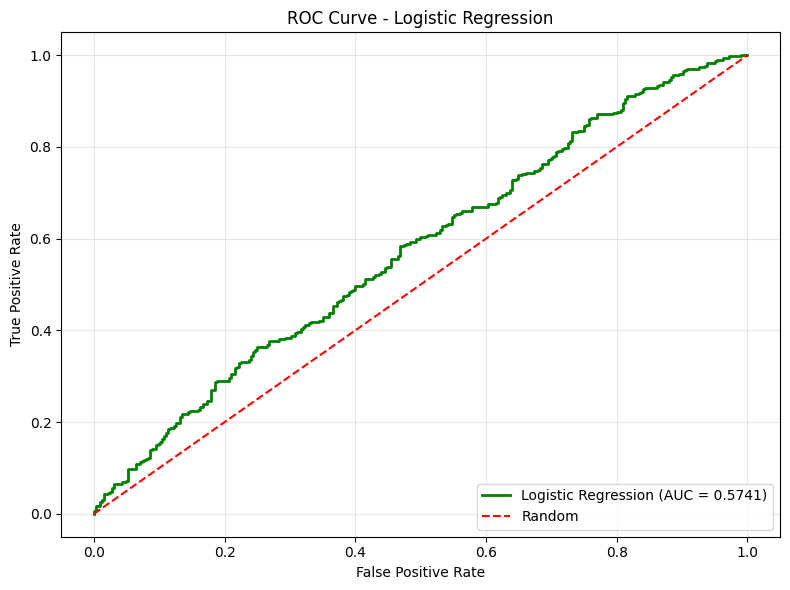

In [24]:
#@title Cell9
# Initialize Logistic Regression with better parameters
logreg_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 20),      # Range of inverse regularization strengths
    cv=5,                           # 5-fold cross-validation
    scoring='roc_auc',              # Optimize for ROC AUC
    max_iter=2000,                  # Increase max iterations
    penalty='l2',                   # L2 regularization
    solver='lbfgs',                 # Efficient solver for L2
    n_jobs=-1,                      # Use all processors
    random_state=42)

# Fit the model
logreg_cv.fit(X_train_scaled, y_train)

# Get predictions
y_pred = logreg_cv.predict(X_test_scaled)
y_pred_prob = logreg_cv.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_lr = roc_auc_score(y_test, y_pred_prob)

# Calculate ROC curve
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve with improved styling
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

quals = pd.DataFrame({'Accuracy':[accuracy], 'AUC':[auc_lr]})
display(quals)

The ROC curve shows an AUC of 0.574, indicating that the logistic regression model performs only slightly better than random guessing (AUC = 0.5). The curve’s proximity to the diagonal line reflects the model's limited ability to distinguish between "enjoyed" and "not enjoyed" songs. This suggests that the current features may not sufficiently capture the patterns in song enjoyment, and the linear nature of logistic regression may not be well-suited for the complexity of the data. We will next try models that do not assume linear relationships between the larget variable and the features.

## Random Forest Classifier

The Random Forest algorithm, a non-linear ensemble method, was applied to capture more complex relationships between features and the outcome. This method builds multiple decision trees and averages their predictions to improve robustness.

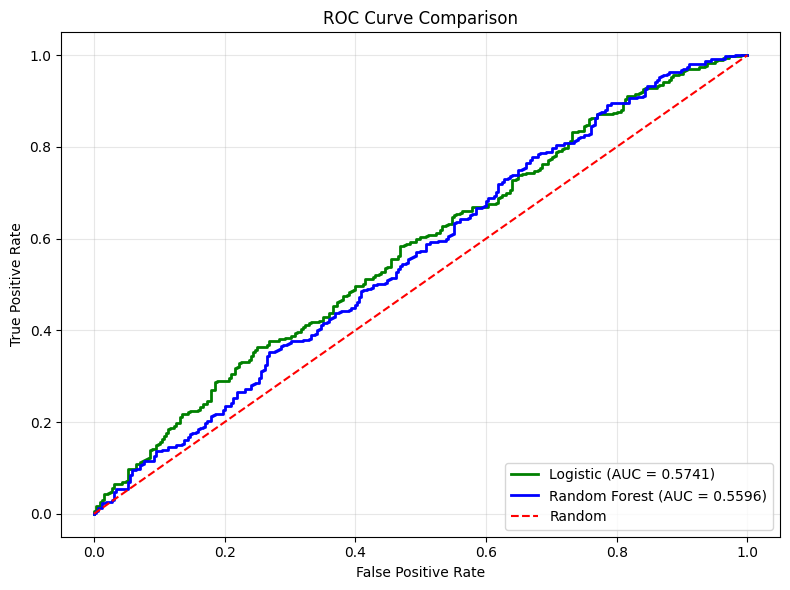

In [25]:
#@title Cell11
# Define the hyperparameter grid for cross-validation
param_distributions = {
    'n_estimators': [100, 200, 300],        # Fewer trees
    'max_depth': [3, 4, 5, 6],              # Much shallower trees
    'min_samples_split': [10, 20, 30],      # Require more samples to split
    'min_samples_leaf': [10, 20, 30],       # Much larger leaf size
    'max_features': ['sqrt']                # Simpler feature selection
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='roc_auc',           # Just use one metric
    verbose=0,
    random_state=42,
    n_jobs=-1
)
# Fit and get predictions
random_search.fit(X_train_scaled, y_train)
best_rf = random_search.best_estimator_

# Get predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate all metrics at once
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_rf = roc_auc_score(y_test, y_pred_prob)

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob)  # We don't need thresholds

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)  # Softer grid
plt.tight_layout()
plt.show();

While Random Forest typically outperforms Logistic Regression due to its ability to capture complex patterns, in this case of predicting music enjoyment, the simpler Logistic Regression model performed better. The Logistic Regression model achieves an AUC of 0.5599, while the Random Forest model slightly improves upon this with an AUC of 0.5644. To thoroughly explore the options for prediction, however, we will evaluate two other powerful ensemble methods: Gradient Boosting and XGBoost. These boosting algorithms might capture patterns that both Random Forest and Logistic Regression missed by learning from previous predictions.

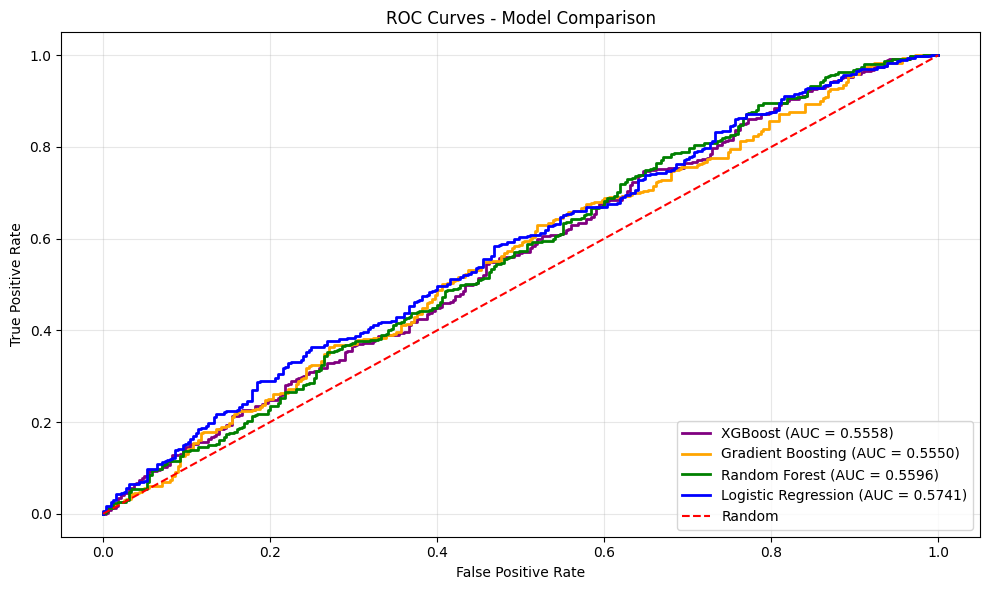

In [26]:
#@title Cell11
# Define parameter grids for both models
xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

gbc_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base models
xgb = XGBClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV for both models
xgb_search = RandomizedSearchCV(
    xgb,
    xgb_params,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

gbc_search = RandomizedSearchCV(
    gbc,
    gbc_params,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit models
xgb_search.fit(X_train_scaled, y_train)
gbc_search.fit(X_train_scaled, y_train)

# Get best models
best_xgb = xgb_search.best_estimator_
best_gbc = gbc_search.best_estimator_

# Get predictions for all models
y_pred_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_gbc = best_gbc.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_prob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

# Plot all ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2, 
         label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot(fpr_gbc, tpr_gbc, color='orange', lw=2, 
         label=f'Gradient Boosting (AUC = {roc_auc_gbc:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, 
         label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', 
         label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

The comparison of the four models reveals remarkably similar performance, with all models achieving AUC scores between 0.55 and 0.58. Logistic Regression achieved the highest AUC of 0.5749, followed by Random Forest (0.5596), XGBoost (0.5558), and Gradient Boosting (0.5550). While all models performed better than random chance (AUC = 0.5), the marginal improvement suggests that predicting song enjoyment based on audio features and metadata alone is a task that requires more granular data. The similar performance across different model complexities, from the simpler Logistic Regression to more complex ensemble methods like XGBoost, suggests that the inherent subjectivity of music preference may limit the predictive power of purely technical audio features.

## Genre Analysis

This section explores the distribution of songs across consolidated genres and their relationship with user enjoyment.

### Consolidating Genres

The first step in the genre analysis was to simplify the raw genre tags into six overarching categories: Mainstream Hip Hop, Underground/Alternative Hip Hop, R&B, African/Diasporic, Lo-Fi, and Other. 

In [27]:
#@title Cell12
def consolidate_genre(genre_list_str):
    """
    Convert a string representation of genre list to one of six categories:
    Mainstream Hip Hop, Underground/Alternative Hip Hop, R&B, African/Diasporic, Lo-Fi, or Other
    
    Args:
        genre_list_str (str): String representation of list of genres
        
    Returns:
        str: Single consolidated genre
    """
    if not isinstance(genre_list_str, str) or genre_list_str == '[]':
        return 'Other'
    
    try:
        genres = [g.strip().strip("'") for g in genre_list_str.strip('[]').split(',')]
        genres = [g.strip('"').lower() for g in genres if g.strip()]
    except:
        return 'Other'
    
    # Check for R&B first (highest priority)
    rb_genres = {'r&b', 'soul', 'neo soul', 'contemporary r&b', 'alternative r&b', 
                'neo r&b', 'indie r&b', 'bedroom r&b', 'trap soul', 'experimental r&b', 
                'dark r&b', 'indie soul'}
    if any(rb_genre in genre.lower() for genre in genres for rb_genre in rb_genres):
        return 'R&B'
    
    # Check for African/Diasporic genres
    african_genres = {
        'afrobeats', 'afropop', 'afroswing', 'amapiano', 'azonto', 'bongo flava',
        'azontobeats', 'musique urbaine kinshasa', 'kuduro', 'zouglou', 'coupe-decale',
        'hiplife', 'alte', 'maimouna', 'asakaa', 'afro house', 'afrofuturism',
        'west african', 'naija', 'tanzanian', 'kenyan', 'ugandan', 'sudanese',
        'african', 'nigerian', 'ghanaian'
    }
    if any(african_genre in genre.lower() for genre in genres for african_genre in african_genres):
        return 'African/Diasporic'
    
    # Check for Lo-Fi
    lofi_genres = {'lo-fi', 'lofi', 'chillhop', 'jazzhop', 'focus beats', 
                   'anime lo-fi', 'lo-fi beats', 'lo-fi study', 'lo-fi sleep'}
    if any(lofi_genre in genre.lower() for genre in genres for lofi_genre in lofi_genres):
        return 'Other'
    
    # Underground/Alternative Hip Hop indicators
    underground_genres = {
        'underground hip hop', 'alternative hip hop', 'experimental hip hop', 'abstract hip hop',
        'indie hip hop', 'conscious hip hop', 'political hip hop', 'jazz rap',
        'lgbtq+ hip hop', 'deep underground hip hop', 'boom bap', 'brooklyn drill',
        'underground rap', 'indie rap', 'abstract rap'
    }
    
    # Mainstream Hip Hop indicators
    mainstream_genres = {
        'pop rap', 'trap', 'melodic rap', 'gangster rap', 'drill', 
        'southern hip hop', 'atl hip hop', 'viral rap', 'pop rap',
        'dirty south rap', 'plugg', 'pluggnb', 'rage rap'
    }
    
    # Check for any hip hop presence
    if any(genre.lower().find('hip hop') != -1 or genre.lower().find('rap') != -1 for genre in genres):
        # Determine which type of hip hop
        if any(underground_genre in genre.lower() for genre in genres for underground_genre in underground_genres):
            return 'Underground/Alternative Hip Hop'
        else:
            return 'Mainstream Hip Hop'
    
    # Everything else goes to Other
    return 'Other'


avg_play2['genres'] = avg_play2['genres'].apply(consolidate_genre)

After consolidating the genres, the distribution of songs across these six categories was visualized using a bar chart. The resulting plot highlights which genres are most prevalent in the dataset.

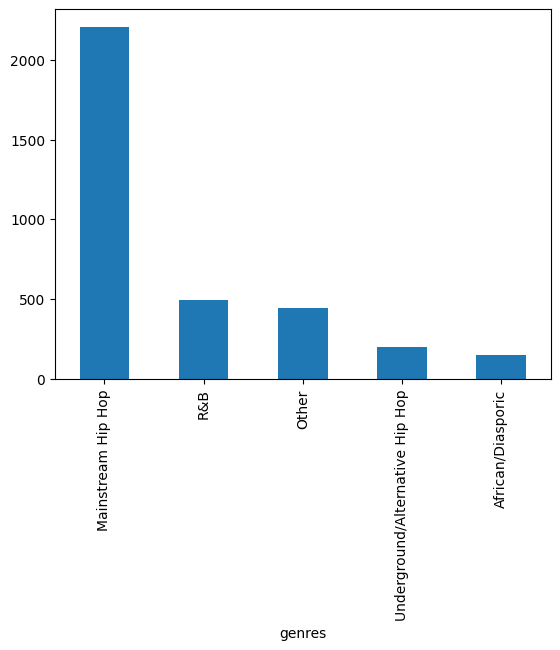

In [28]:
#@title Cell13
avg_play2['genres'].value_counts().plot(kind='bar');

From the chart, it is evident that Mainstream Hip Hop overwhelmingly dominates my listening history, with significantly smaller contributions from genres like R&B, Other, and African/Diasporic.

### Enjoyment Across Genres

Next, we explore the relationship between song enjoyment and genre. The distribution of enjoyed versus not enjoyed songs was plotted side-by-side for each genre, followed by a proportional analysis.

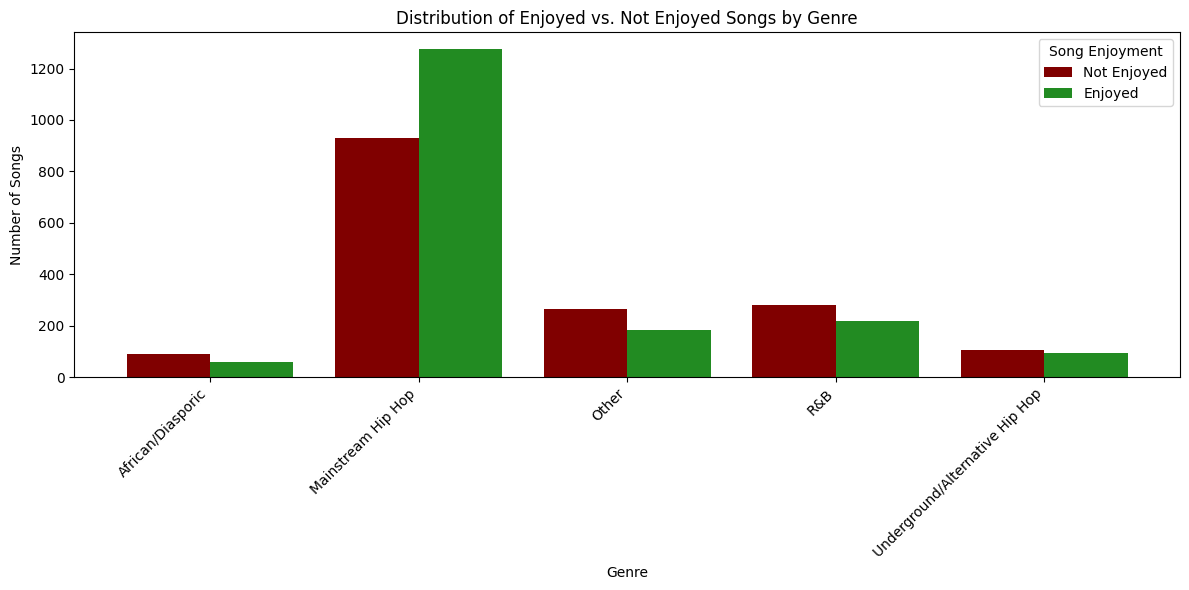

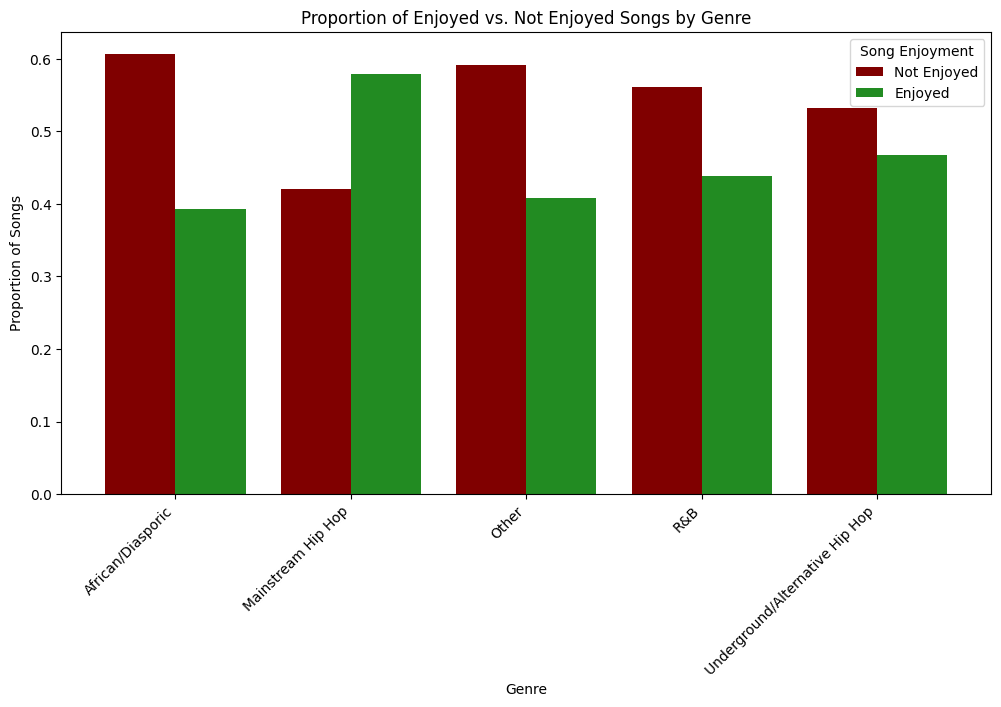

In [29]:
#@title Cell14

# Plot the distribution of enjoyed songs by genre side-by-side
# Group by 'genres' and 'enjoyed', and count the number of songs
genre_counts = avg_play2.groupby(['genres', 'enjoyed']).size().unstack(fill_value=0)

# Plot side-by-side bars
genre_counts.plot(kind='bar', figsize=(12, 6), width=0.8, color=['maroon', 'forestgreen'])

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Enjoyed vs. Not Enjoyed Songs by Genre')
plt.legend(['Not Enjoyed', 'Enjoyed'], title='Song Enjoyment')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

# Also plot the proportion of enjoyed songs by genre
genre_counts2 = genre_counts.div(genre_counts.sum(axis=1), axis=0)
genre_counts2.plot(kind='bar', figsize=(12, 6), width=0.8, color=['maroon', 'forestgreen'])

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Proportion of Songs')
plt.title('Proportion of Enjoyed vs. Not Enjoyed Songs by Genre')
plt.legend(['Not Enjoyed', 'Enjoyed'], title='Song Enjoyment')
plt.xticks(rotation=45, ha='right');  # Rotate x-axis labels


The first plot shows the raw counts of enjoyed and not enjoyed songs across genres. Notably, Mainstream Hip Hop has the largest number of enjoyed songs, but it also contains a substantial portion of not enjoyed tracks. In contrast, genres like African/Diasporic and Underground/Alternative Hip Hop have fewer total songs but a higher proportion of not enjoyed tracks. This may prove to be a challenge for the predictive models, as there is clear imbalance across the different genres.

In [30]:
#@title Cell15
# List of genres to iterate over
genres = genre_counts.index.tolist()

# Define features and target column
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'liveness', 'valence', 'tempo', 'track_popularity']
target = 'enjoyed'

# Dictionary to store evaluation metrics for each genre
genre_results = {}

# Loop through each genre and fit logistic regression models
for genre in genres:
    #print(f"Training model for genre: {genre}")
    
    # Filter data for the current genre
    genre_data = avg_play2[avg_play2['genres'] == genre]
    
    # Proceed only if the genre has sufficient data
    if genre_data.shape[0] < 20:
        print(f"Skipping {genre} due to insufficient data.")
        continue
    
    # Define X (features) and y (target)
    X = genre_data[features].dropna()
    y = genre_data.loc[X.index, target]  # Align y with X
    
    # Skip if target has only one class
    if len(y.unique()) < 2:
        print(f"Skipping {genre} because only one class is present in 'enjoyed'.")
        continue
    
    # Split into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply SMOTE to balance the training set
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Initialize and fit logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_res, y_train_res)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    genre_results[genre] = {
        'accuracy': report['accuracy'],
        'precision': report['True']['precision'] if 'True' in report else 0,
        'recall': report['True']['recall'] if 'True' in report else 0,
        'f1-score': report['True']['f1-score'] if 'True' in report else 0,
        'auc': auc
    }

    #print(f"Accuracy: {report['accuracy']:.4f}, AUC: {auc:.4f}")

# Convert results dictionary to a DataFrame for summary
results_df = pd.DataFrame(genre_results).T
display(results_df)


,accuracy,precision,recall,f1-score,auc
African/Diasporic,0.466667,0.333333,0.333333,0.333333,0.328704
Mainstream Hip Hop,0.566893,0.620301,0.647059,0.633397,0.560869
Other,0.600000,0.510638,0.648649,0.571429,0.555839
R&B,0.540000,0.480769,0.568182,0.520833,0.592532
Underground/Alternative Hip Hop,0.475000,0.461538,0.631579,0.533333,0.516291


The logistic regression models, with SMOTE applied to address class imbalance, showed varying performance across genres. Mainstream Hip Hop and Other achieved the best results, with accuracy around 57-60% and AUC values of 0.56, indicating moderate predictive ability. Recall was generally high, particularly for Underground/Alternative Hip Hop (0.63), reflecting the model's strength in identifying "enjoyed" songs, though precision remained lower. In contrast, African/Diasporic performed poorly (AUC = 0.33), likely due to limited data. Overall, performance improved for minority class predictions, but smaller genres still pose challenges due to data scarcity.

## K-Nearest-Neighbors for Enjoyment Prediction

To wrap up the genre analysis, we employ the K-Nearest Neighbors (KNN) algorithm to explore how well song enjoyment can be predicted using a combination of audio features and genre information. KNN is a simple yet effective classification method that assigns labels to data points based on the majority class of their k closest neighbors in feature space.

By incorporating both genre data and audio characteristics like danceability, energy, and tempo, we aim to determine whether these attributes collectively influence the likelihood of a song being enjoyed. This step helps assess if genre plays a significant role in enjoyment prediction or if other song features are more critical.

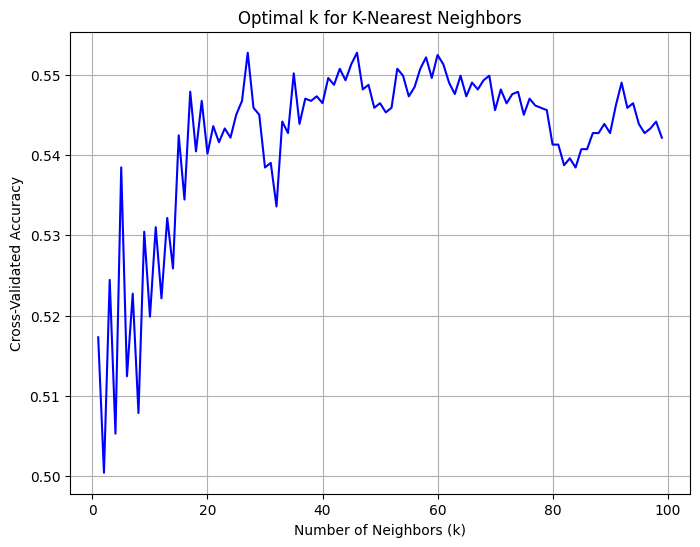

In [31]:
#@title Cell16
# One-hot encode the 'genres' column
avg_play2 = pd.get_dummies(avg_play2, columns=['genres'])

# Define features and target column
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'liveness', 'valence', 'tempo', 'track_popularity'] + \
            [col for col in avg_play2.columns if 'genres' in col] + \
            [col for col in avg_play2.columns if 'time_signature' in col or 'key' in col]

target = 'enjoyed'

# Prepare X (features) and y (target)
X = avg_play2[features].dropna()
y = avg_play2.loc[X.index, target]

# Standardize the features for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Find the best k (number of neighbors)
k_values = range(1, 100)  # Test k values
mean_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')
    mean_accuracies.append(np.mean(scores))
    #print(f"k = {k}, Mean Accuracy: {np.mean(scores):.4f}")

# Find the best k
best_k = k_values[np.argmax(mean_accuracies)]
#print(f"\nBest k: {best_k}, Accuracy: {max(mean_accuracies):.4f}")

# Plot k vs. cross-validated accuracy
plt.figure(figsize=(8, 6))
plt.plot(k_values, mean_accuracies, linestyle='-', color='blue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal k for K-Nearest Neighbors')
plt.grid()
plt.show()

The plot shows the cross-validated accuracy of a K-Nearest Neighbors (KNN) model as the number of neighbors k increases. The accuracy improves consistently as k rises from small values, stabilizing around k=27, where it reaches one of its peaks. This suggests that k=27 offers an optimal trade-off: it balances the model's ability to generalize without overfitting to noise, while still maintaining strong interpretability compared to higher k-values. After k=27, the accuracy fluctuates slightly but remains relatively stable around 54-55%. This stabilization indicates diminishing returns as k increases further. Larger k-values smooth out predictions but may reduce the model's sensitivity to more nuanced patterns.

Despite incorporating audio features and genre data, the model's best accuracy remains modest (around 55%). This suggests that listening behavior may not be fully captured by the available data. Important factors such as mood, context (e.g., time of day), personal associations with songs, or unexplored song metadata (like lyrics or artist familiarity) likely influence enjoyment and are absent from the current dataset. Further enhancements, such as including temporal trends, song sequencing, or contextual features, could better model these behaviors.

## Experimenting With More Granular Notions of Enjoyment

### Granular Enjoyment Score

Lastly, we propose an enjoyment score is designed to capture the degree of enjoyment for each song based on three key components:

- Completion Rate: The proportion of the song that was listened to, indicating engagement.
- Play Count: The number of times a song was replayed, reflecting repeat enjoyment.
- Track Popularity: Adjusts for song popularity to account for bias towards mainstream music.

These components are combined into a weighted score to reflect enjoyment more precisely, defined as follows:

$$
\text{Enjoyment Score} = w_1 \times \text{Completion Rate} + w_2 \times \log(\text{Play Count} + 1) + w_3 \times \text{Track Popularity (normalized)}
$$

- $w_1, w_2, w_3$ are weights to control the contribution of each component.
- Logarithmic scaling for play count ensures diminishing returns for songs played many times.
- Normalization of track popularity keeps it in line with other features for balanced influence.

This granular score provides a richer, continuous measure of song enjoyment compared to a binary "Enjoyed" or "Not Enjoyed" outcome.


In [34]:
%%capture
# Copy of data
data = avg_play2.copy()

# Normalize track popularity
scaler = MinMaxScaler()
data['track_popularity_normalized'] = scaler.fit_transform(data[['track_popularity']])

# Features and target
X = data[['avg_completion_rate', 'total_plays', 'track_popularity_normalized']]
y = data['enjoyed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate enjoyment score
def enjoyment_score(w1, w2, w3, X):
    return (
        w1 * X['avg_completion_rate'] + 
        w2 * np.log1p(X['total_plays']) + 
        w3 * X['track_popularity_normalized']
    )

# Define a function to optimize weights
def optimize_weights(params):
    w1, w2, w3 = params
    X_train['enjoyment_score'] = enjoyment_score(w1, w2, w3, X_train)
    X_test['enjoyment_score'] = enjoyment_score(w1, w2, w3, X_test)
    
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train[['enjoyment_score']], y_train)
    y_pred = model.predict_proba(X_test[['enjoyment_score']])[:, 1]
    
    # Evaluate using ROC-AUC
    return -roc_auc_score(y_test, y_pred)  # Negative because we minimize in optimization

# Grid Search over weights

# Initial weights and bounds
initial_weights = [0.3, 0.3, 0.4]  # Start with equal weights
bounds = [(0, 1), (0, 1), (0, 1)]  # Each weight is between 0 and 1

# Optimization
result = minimize(optimize_weights, initial_weights, bounds=bounds, method='L-BFGS-B')

# Best weights
best_weights = result.x
weight1 = [best_weights[0]]
weight2 = [best_weights[1]]
weight3 = [best_weights[2]]

To optimize the weights for the enjoyment score components, a logistic regression model was used to predict whether a song was "enjoyed." The weights for completion rate, play count, and track popularity were optimized using `scipy`'s minimize function, which aimed to maximize the predictive performance measured by ROC-AUC. The objective function calculated the negative ROC-AUC for each combination of weights, allowing the optimizer to adjust the contributions of each component iteratively. The resulting optimal weights of $w_1 = 0.3$, $w_2 = 0.3$, and $w_3 = 0.4$ provide the best balance to predict enjoyment based on the data. The distribution of enjoyment scores can be found below:

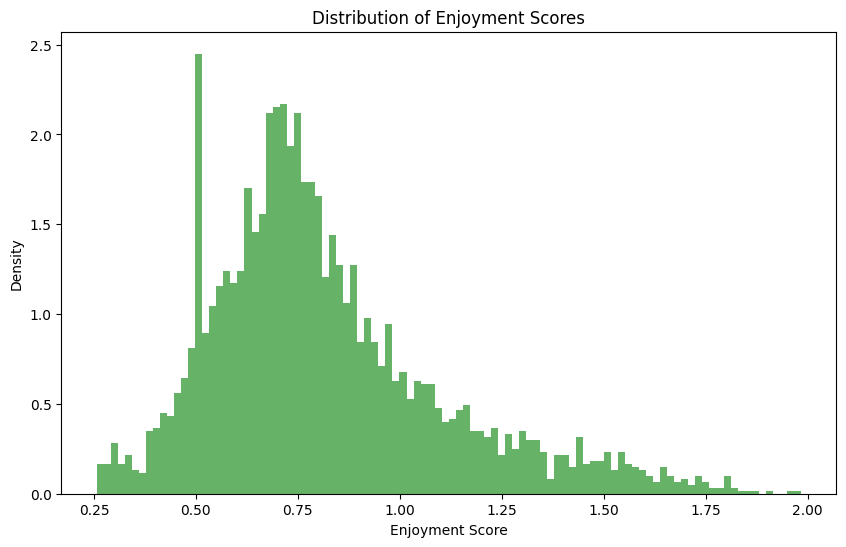

In [35]:
#@title Cell17
data['enjoyment_score'] = enjoyment_score(*best_weights, data)

# Plot the distribution of enjoyment scores
plt.figure(figsize=(10, 6))
plt.hist(data['enjoyment_score'], bins=100, alpha=0.6, color='green', density=True)
plt.xlabel('Enjoyment Score')
plt.ylabel('Density')
plt.title('Distribution of Enjoyment Scores')
plt.show();

Having previously explored binary enjoyment classification (enjoyed vs. not enjoyed), we now shift to predicting enjoyment scores as a continuous variable for a more nuanced understanding of user preferences by capturing varying levels of enjoyment rather than reducing the outcome to a binary decision.

By applying regression models, we aim to identify the specific song attributes and features that influence enjoyment scores the most. We again employ Ridge and Lasso Regression, Random Forest, and XGBoost to determine their predictive accuracy and feature importance.

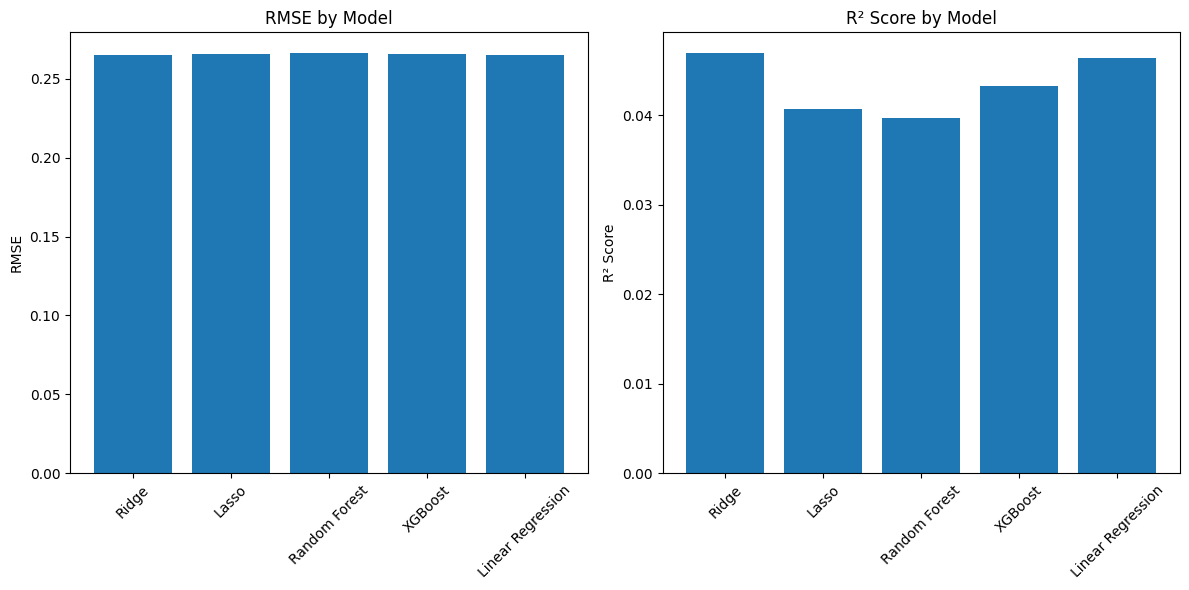

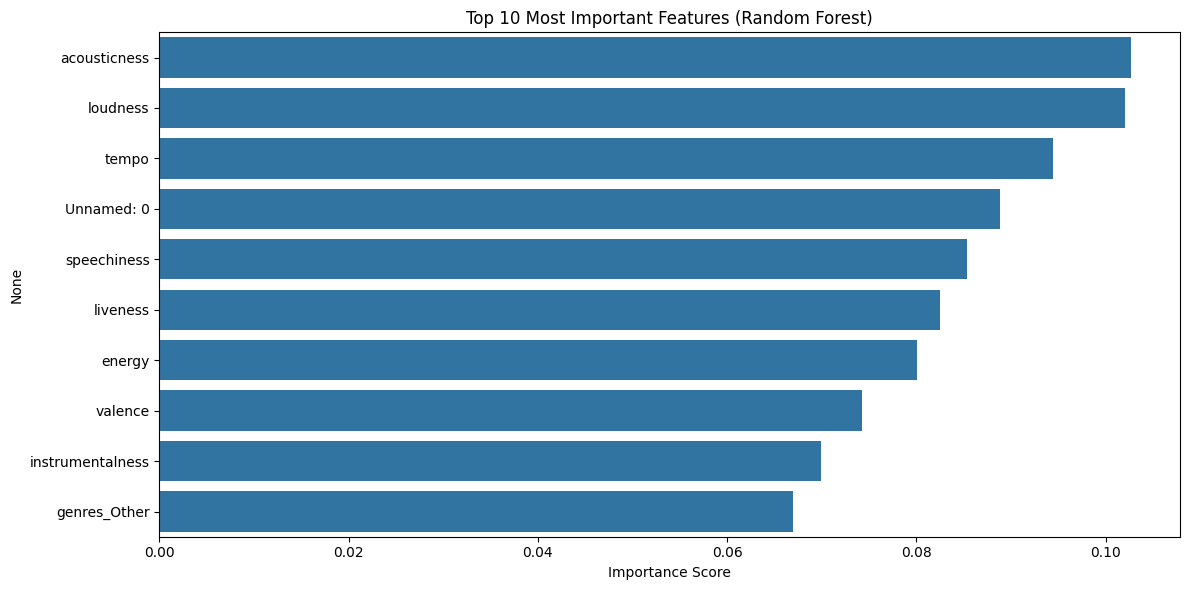

In [37]:
#@title Cell18
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

def prepare_features(df):
    """Prepare features for model training."""
    drop_columns = ['track_id', 'artist_id', 'track_name', 'artist_name', 
                   'enjoyed', 'enjoyment_score', 'play_category', "total_plays",
                   'track_popularity', 'track_popularity_normalized', 'avg_completion_rate', 'average_seconds_played']
    
    features = df.drop(columns=drop_columns)
    
    return features

def perform_hyperparameter_tuning(X_train_scaled, y_train):
    """Perform grid search for hyperparameter tuning."""
    param_grids = {
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                'solver': ['auto', 'svd', 'cholesky']
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                'selection': ['cyclic', 'random']
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
            'params': {
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3],
                'n_estimators': [100, 200]
            }
        }
    }
    
    best_models = {}
    
    for name, config in param_grids.items():
        #print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train)
        
        #print(f"Best parameters: {grid_search.best_params_}")
        #print(f"Best RMSE: {-grid_search.best_score_:.4f}")
        
        best_models[name] = grid_search.best_estimator_
    
    return best_models

def visualize_results(results, feature_importance):
    """Create visualizations for model performance and feature importance."""
    # Model Performance Comparison
    plt.figure(figsize=(12, 6))
    
    # RMSE Comparison
    plt.subplot(1, 2, 1)
    rmse_scores = [metrics['RMSE'] for metrics in results.values()]
    plt.bar(results.keys(), rmse_scores)
    plt.title('RMSE by Model')
    plt.xticks(rotation=45)
    plt.ylabel('RMSE')
    
    # R² Comparison
    plt.subplot(1, 2, 2)
    r2_scores = [metrics['R2'] for metrics in results.values()]
    plt.bar(results.keys(), r2_scores)
    plt.title('R² Score by Model')
    plt.xticks(rotation=45)
    plt.ylabel('R² Score')
    
    plt.tight_layout()
    
    # Feature Importance Plot
    if 'Random Forest' in feature_importance:
        plt.figure(figsize=(12, 6))
        top_features = feature_importance['Random Forest'].head(10)
        sns.barplot(x=top_features.values, y=top_features.index)
        plt.title('Top 10 Most Important Features (Random Forest)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
    
    plt.show()

def predict_enjoyment(df):
    """Main function to run the enjoyment prediction pipeline."""
    # Prepare features
    X = prepare_features(df)
    y = df['enjoyment_score']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform hyperparameter tuning
    #print("Performing hyperparameter tuning...")
    best_models = perform_hyperparameter_tuning(X_train_scaled, y_train)
    
    # Add Linear Regression (no hyperparameters to tune)
    best_models['Linear Regression'] = LinearRegression()
    best_models['Linear Regression'].fit(X_train_scaled, y_train)
    
    results = {}
    feature_importance = {}
    
    # Evaluate each tuned model
    for name, model in best_models.items():
        if name != 'Linear Regression':  # Skip Linear Regression as it's already fitted
            model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'RMSE': rmse,
            'R2': r2
        }
        
        # Get feature importance if available
        if hasattr(model, 'feature_importances_'):
            feature_importance[name] = pd.Series(
                model.feature_importances_,
                index=X_train.columns
            ).sort_values(ascending=False)
        elif name == 'Linear Regression':
            feature_importance[name] = pd.Series(
                model.coef_,
                index=X_train.columns
            ).abs().sort_values(ascending=False)
    
    # Print results
    # print("\nModel Performance Comparison:")
    # print("-" * 50)
    # for model_name, metrics in results.items():
    #     print(f"\n{model_name}:")
    #     print(f"RMSE: {metrics['RMSE']:.4f}")
    #     print(f"R2 Score: {metrics['R2']:.4f}")
    
    # Create visualizations
    visualize_results(results, feature_importance)
    
    return results, feature_importance, scaler, best_models

results, feature_importance, scaler, best_models = predict_enjoyment(data)

The machine learning models' performance in predicting music enjoyment scores reveals several interesting patterns. Looking at the evaluation metrics, all models showed relatively consistent RMSE values around 0.26, indicating similar prediction accuracy across different approaches. However, the R² scores, which measure the proportion of variance explained by the models, show more notable differences.

Linear Regression and Ridge Regression performed best with R² scores around 0.045 (4.5%), followed by XGBoost at approximately 0.042 (4.2%). The Random Forest and Lasso models showed slightly lower performance with R² scores around 0.03-0.04 (3-4%). Granted, these R² values are relatively low, providing more evidence that predicting music enjoyment is a complex task that may involve factors beyond the available features. However, they still provide valuable insights into feature importance, revealing the following:

1. Audio Characteristics: The top three predictors are loudness, acousticness, and tempo, suggesting that the technical aspects of a song's production and composition significantly influence listener enjoyment.

2. Vocal Elements: Speechiness and liveness rank highly (4th and 5th), indicating that the presence and quality of vocal components play a substantial role in listener engagement.

3. Emotional and Energy Factors: Valence (emotional positivity) and energy appear as the 6th and 7th most important features, showing that a song's emotional content and energy level are meaningful predictors of enjoyment.

4. Musical Structure: Danceability and instrumentalness round out the top features, demonstrating that the overall musical structure and composition style contribute to listener enjoyment.

5. Genre Impact: The presence of `genres_Other` in the top 10 suggests that genre classification has some predictive power, though relatively lower than the audio features.

# Conclusion

This analysis investigated the factors influencing music enjoyment using publicly available Spotify audio features and metadata. By applying a range of statistical and machine learning models, including LASSO regression, logistic regression, Random Forest, and XGBoost, we seek to predict whether a song would be “enjoyed” based on attributes like track popularity, danceability, loudness, and acousticness. Despite the sophistication of the methods employed, model performance plateaued at around 55-57% AUC, demonstrating only modest predictive power. The results revealed that while features such as track popularity, danceability, and speechiness were positively associated with enjoyment, and acousticness and liveness were negatively associated, these attributes alone fail to fully capture the complexity of listening preferences.

The limited accuracy achieved in this analysis raises a critical point about the nature of data available to the public. Streaming platforms like Spotify are known for their exceptional ability to curate highly personalized recommendations, which cannot be explained solely by the audio features and metadata analyzed here. This discrepancy suggests that Spotify—and likely other streaming services—possess far more granular data about individual users. Such data likely includes behavioral patterns, temporal listening trends, mood associations, device information, and possibly third-party data sources that build comprehensive personal profiles. These platforms may also integrate data from other means of personal identification, such as social media behaviors, location history, or interactions with advertisements, to construct robust models that predict user preferences with far greater accuracy.

The plateau observed in this study serves as indirect evidence of the extent and sophistication of the proprietary data Spotify leverages. The limited predictive power of publicly accessible data highlights its constraints, while simultaneously underscoring the opaque nature of data collection practices employed by these platforms. Users benefit from highly tailored recommendations, but this comes at the cost of extensive data collection, often with limited transparency regarding what data is collected, how it is used, and whether it is shared with third parties.

In conclusion, while this analysis sheds light on the relationship between song attributes and user enjoyment, it also highlights the critical role of proprietary, granular data in driving the success of music recommendation systems. Future research could incorporate richer behavioral and contextual data—such as listening times, sequential song patterns, and emotional sentiment—to better approximate the models used by platforms like Spotify. Additionally, this raises broader questions about data privacy and transparency: as consumers, we must remain aware of how much streaming services know about us and the extent to which our personal data fuels their algorithms.


# Appendix

## Figure 1

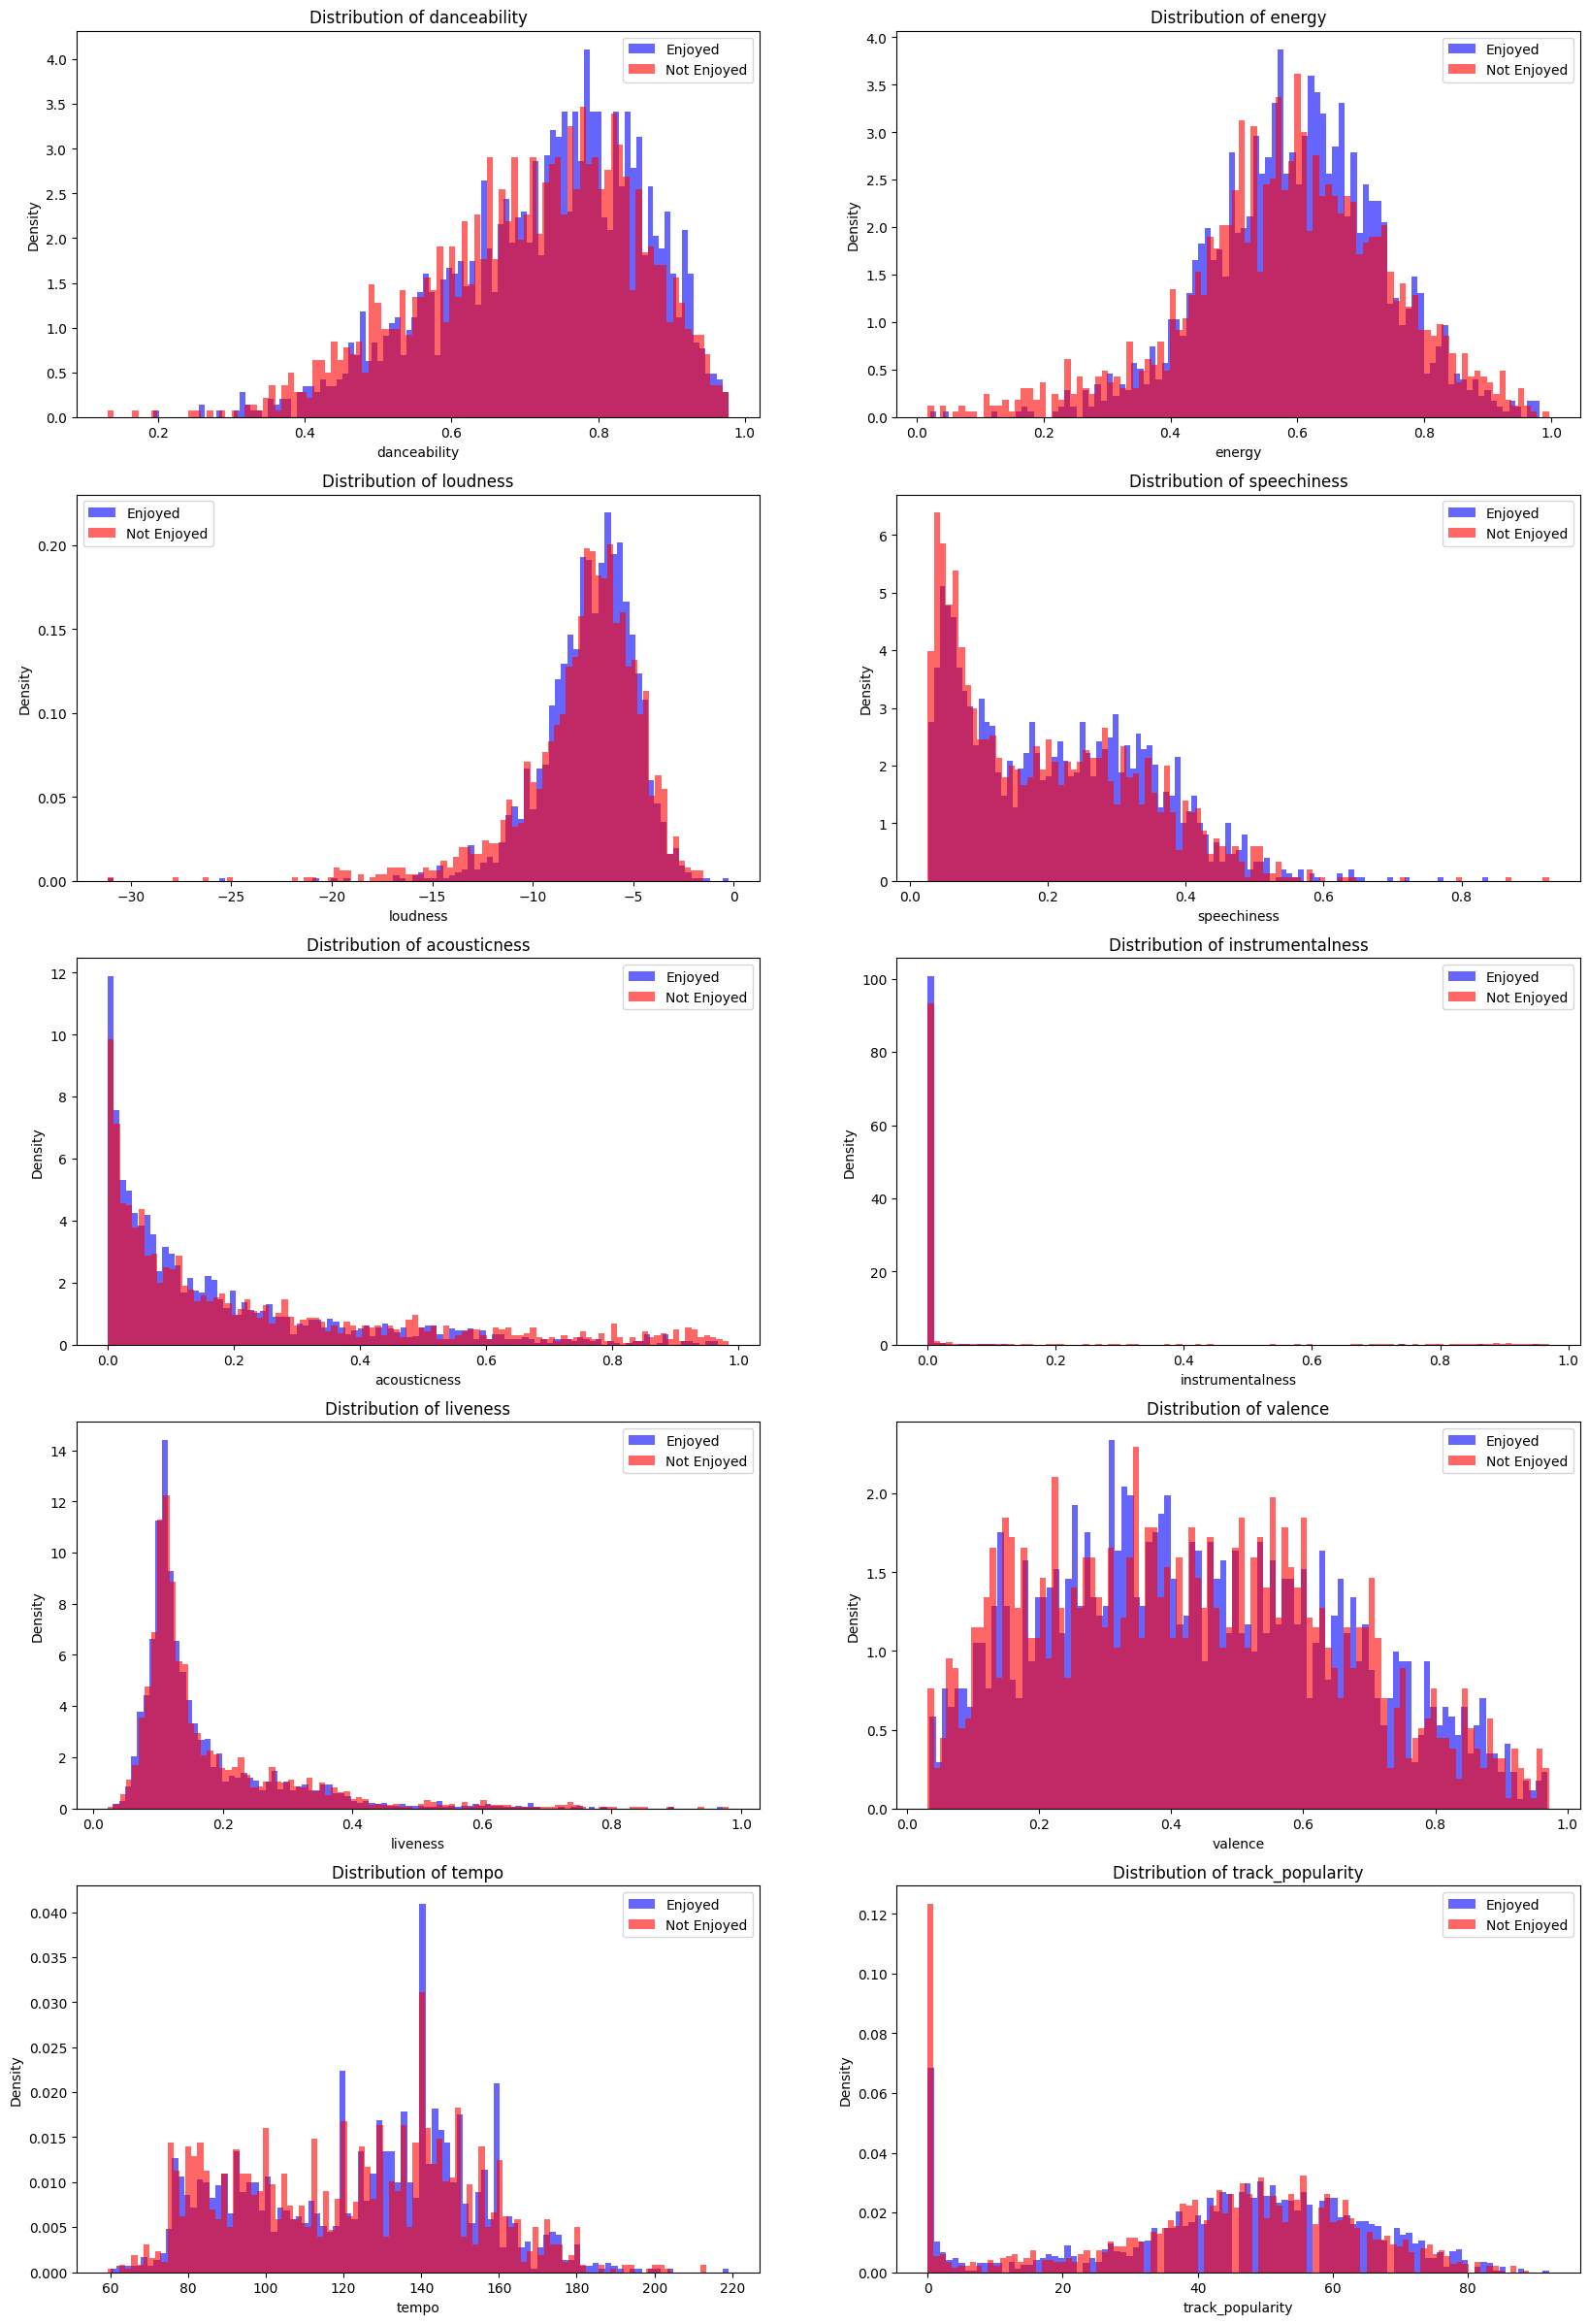

In [15]:
#@title Cell5
# Plot the distribution of each audio feature in a grid of subplots
plt.figure(figsize=(20, 30))
for i, feature in enumerate(audio_features):
    plt.subplot(5, 2, i + 1)
    plt.hist(avg_play2[avg_play2['enjoyed'] == True][feature], bins=100, alpha=0.6, label='Enjoyed', color='blue', density=True)
    plt.hist(avg_play2[avg_play2['enjoyed'] == False][feature], bins=100, alpha=0.6, label='Not Enjoyed', color='red', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)
    plt.legend()

## Figure 2

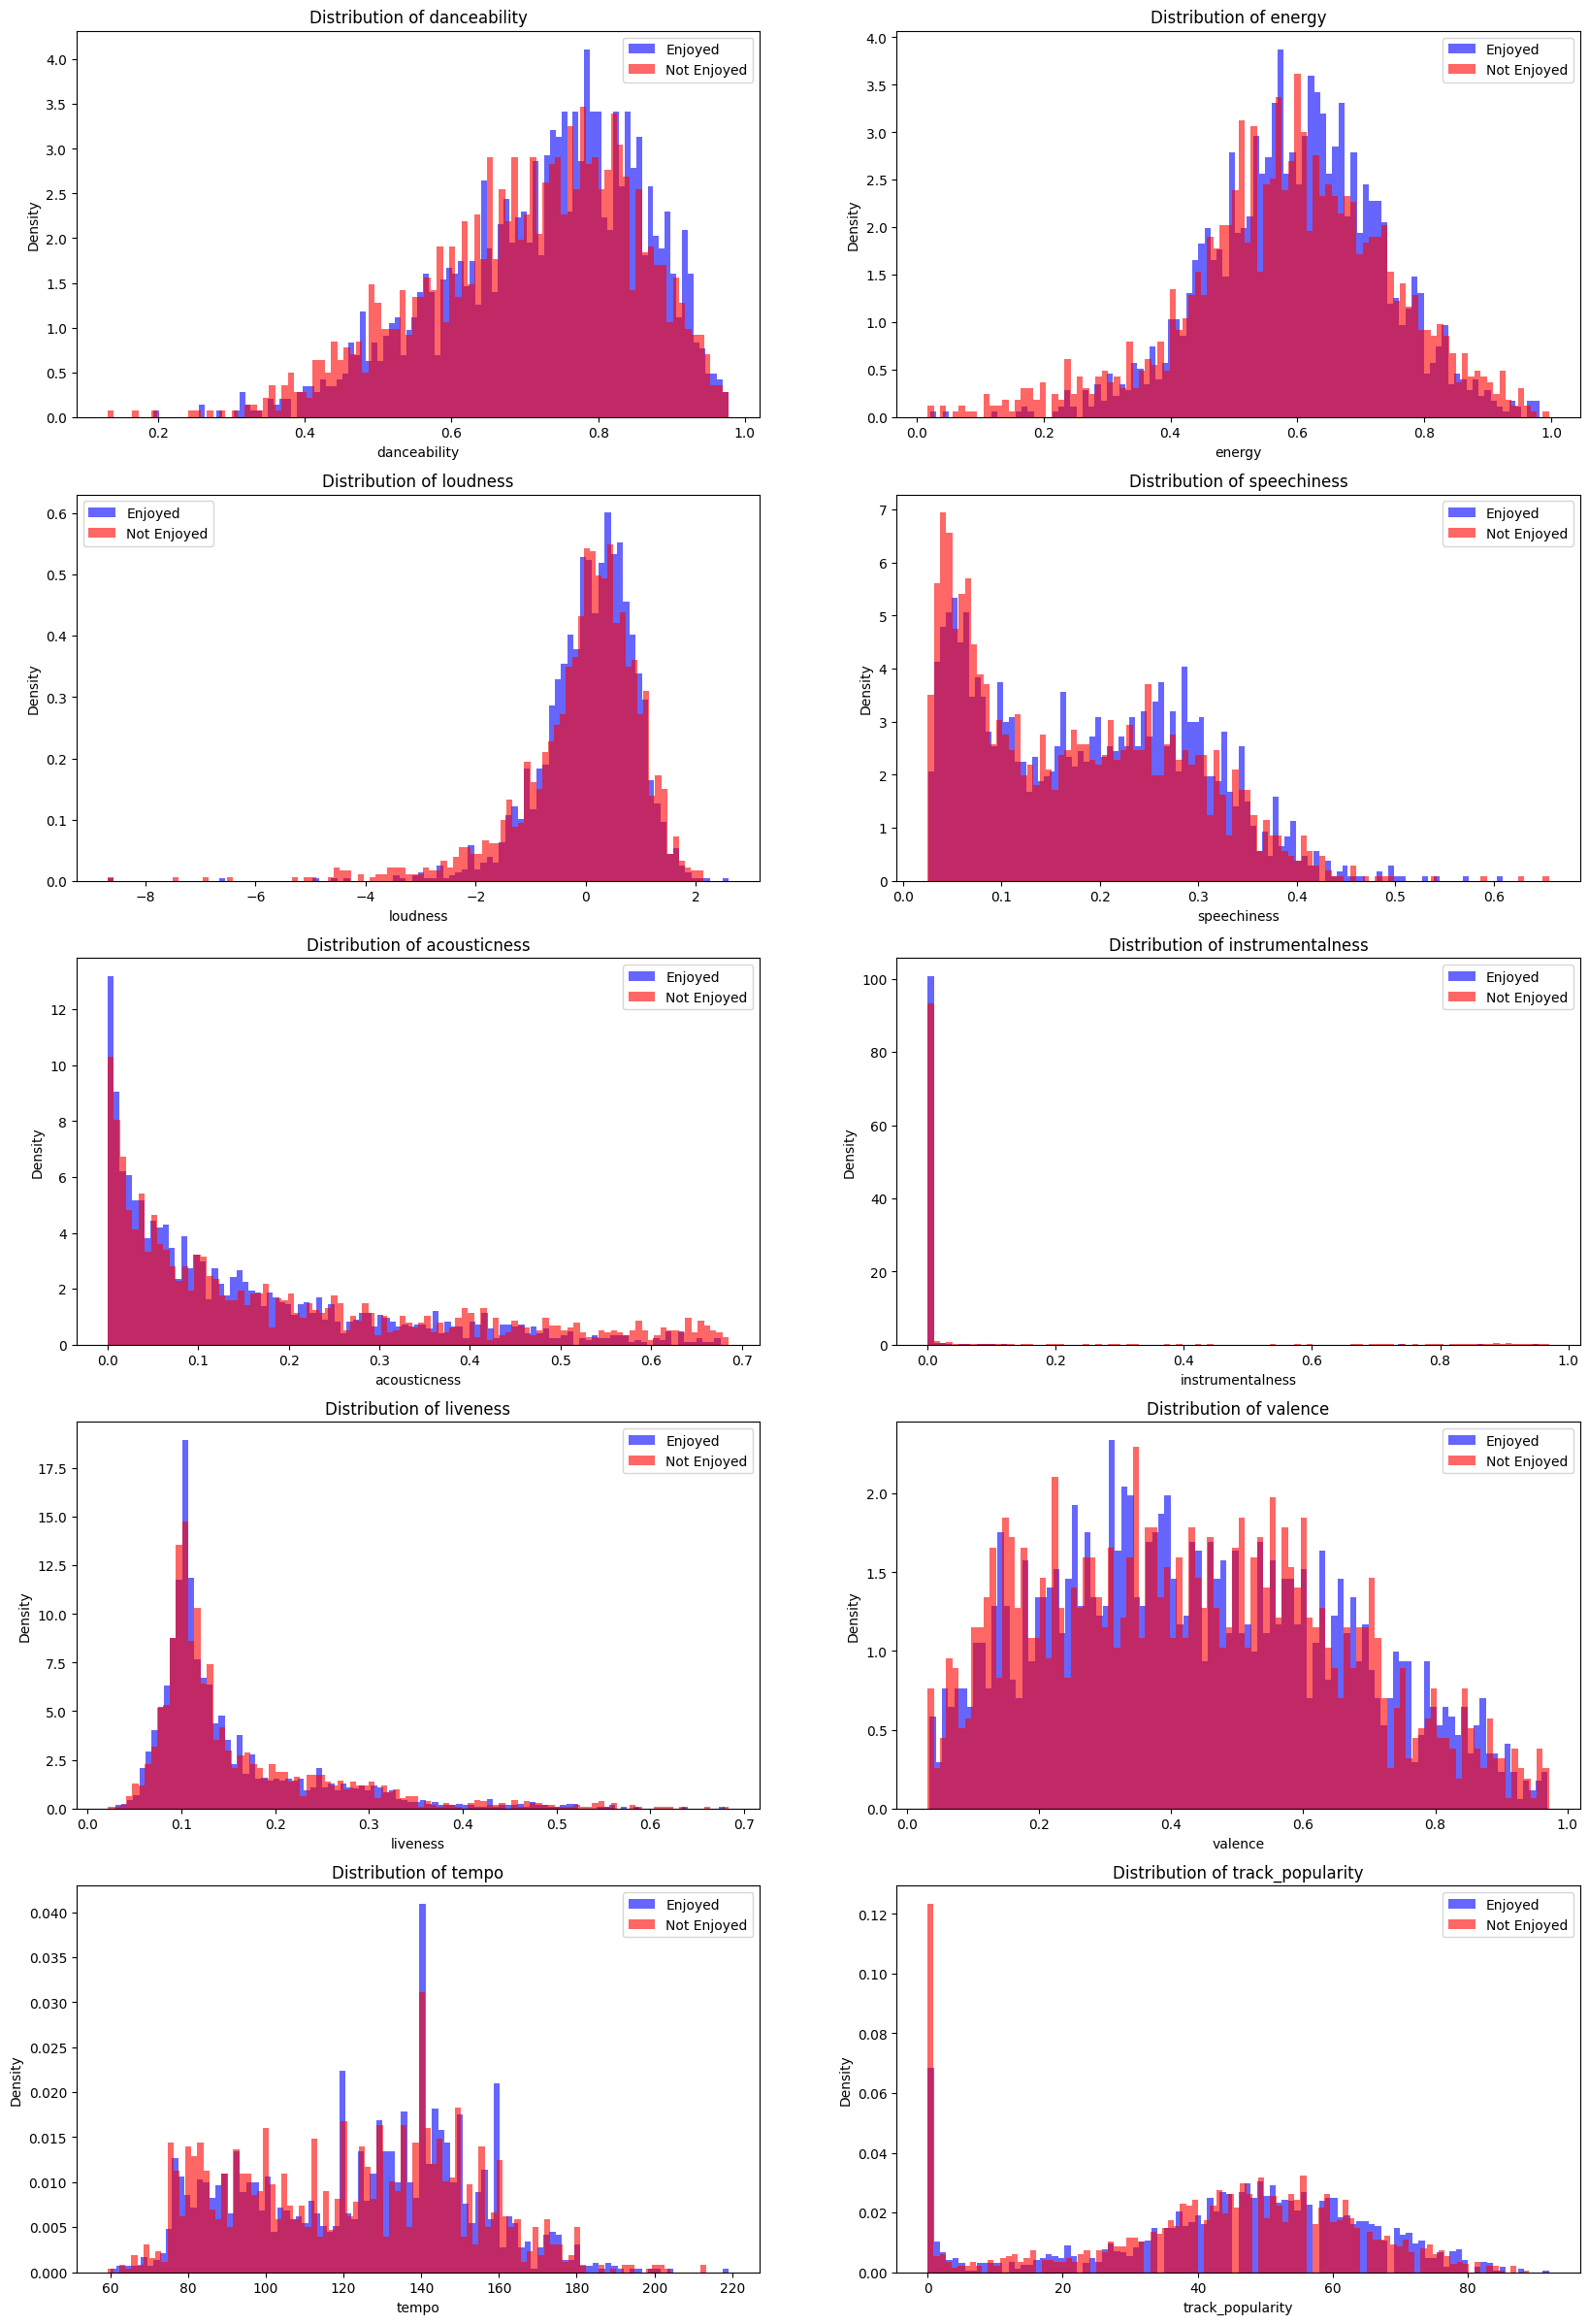

In [16]:
#@title Cell6
# Plot the distribution of each audio feature in a grid of subplots
avg_play2['loudness'] = (avg_play2['loudness'] - avg_play2['loudness'].mean()) / avg_play2['loudness'].std()
avg_play2['acousticness'] = np.log1p(avg_play2['acousticness'])
avg_play2['speechiness'] = np.log1p(avg_play2['speechiness'])
avg_play2['liveness'] = np.log1p(avg_play2['liveness'])

plt.figure(figsize=(20, 30))
for i, feature in enumerate(audio_features):
    plt.subplot(5, 2, i + 1)
    plt.hist(avg_play2[avg_play2['enjoyed'] == True][feature], bins=100, alpha=0.6, label='Enjoyed', color='blue', density=True)
    plt.hist(avg_play2[avg_play2['enjoyed'] == False][feature], bins=100, alpha=0.6, label='Not Enjoyed', color='red', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)
    plt.legend()

In [29]:
%%capture
import nbformat
from nbconvert import LatexExporter
import subprocess
import os

def create_latex_document(body_content, title, author, date):
    """Create a clean LaTeX document with all required packages"""
    document = f"""\\documentclass[11pt]{{article}}

% Essential packages
\\usepackage[utf8]{{inputenc}}
\\usepackage[T1]{{fontenc}}
\\usepackage[margin=1in]{{geometry}}
\\usepackage{{graphicx}}
\\usepackage{{float}}
\\usepackage{{hyperref}}
\\usepackage{{amsmath}}
\\usepackage{{amssymb}}
\\usepackage{{adjustbox}}
\\usepackage{{fancyvrb}}
\\usepackage{{ulem}}
\\usepackage{{unicode-math}}
\\usepackage{{textcomp}}
\\usepackage{{listings}}

% Define tightlist command used by pandoc
\\providecommand{{\\tightlist}}{{%
  \\setlength{{\\itemsep}}{{0pt}}\\setlength{{\\parskip}}{{0pt}}}}

% Configure listings for code blocks
\\lstset{{
    basicstyle=\\ttfamily\\small,
    breaklines=true,
    frame=single,
    numbers=left,
    numberstyle=\\tiny,
    showstringspaces=false
}}

% Title information
\\title{{{title}}}
\\author{{{author}}}
\\date{{{date}}}

\\begin{{document}}
\\maketitle

{body_content}

\\end{{document}}"""
    return document

def convert_notebook_to_latex(input_notebook):
    """Convert Jupyter notebook to LaTeX with error handling"""
    try:
        with open(input_notebook, "r", encoding="utf-8") as f:
            notebook_content = nbformat.read(f, as_version=4)
        
        latex_exporter = LatexExporter()
        latex_exporter.template_file = 'base'
        
        # Convert notebook to LaTeX
        body, resources = latex_exporter.from_notebook_node(notebook_content)
        
        # Clean up the body content
        body = body.split('\\begin{document}')[-1].split('\\end{document}')[0]
        
        # Handle image paths
        outputs = resources.get('outputs', {})
        for output_file, output_data in outputs.items():
            if output_file.endswith(('.png', '.jpg', '.jpeg')):
                # Ensure output directory exists
                os.makedirs('output', exist_ok=True)
                
                # Save the image file
                output_path = os.path.join('output', output_file)
                with open(output_path, 'wb') as f:
                    f.write(output_data)
                
                # Update the reference in the LaTeX content
                body = body.replace(output_file, os.path.join('output', output_file))
        
        return body.strip()
    except Exception as e:
        print(f"Error in notebook conversion: {str(e)}")
        raise

# Main execution
try:
    input_notebook = "Report.ipynb"
    output_tex = "Report.tex"
    
    print(f"Converting {input_notebook} to LaTeX...")
    body_content = convert_notebook_to_latex(input_notebook)
    
    print("Creating LaTeX document...")
    full_document = create_latex_document(
        body_content,
        "Spotify Unwrapped: Deconstructing the Music Personalization Process",
        "Mark Ayiah",
        "December 17, 2024"
    )
    
    print(f"Saving to {output_tex}...")
    with open(output_tex, "w", encoding="utf-8") as f:
        f.write(full_document)
    
    print("\nCompiling LaTeX to PDF...")
    # Run pdflatex twice for references
    for _ in range(2):
        result = subprocess.run(
            ["pdflatex", "-interaction=nonstopmode", output_tex],
            capture_output=True,
            text=True,
            check=False
        )
        if result.returncode != 0:
            print("pdflatex output:")
            print(result.stdout)
            print("\npdflatex errors:")
            print(result.stderr)
    
    print("\nPDF generation completed!")

except Exception as e:
    print(f"Error: {str(e)}")